## Building small gpt-2 like model

124M params model

https://huggingface.co/openai-community/gpt2/blob/main/config.json

In [46]:
import torch
import torch.nn as nn

In [47]:
config = {
    "vocab_size": 50257,     # vocabulary size
    "context_length": 1024,  # context length
    "d_model": 768,          # Embedding dimension | hidden size
    "num_heads": 12,         # Number of attention heads
    "num_layers": 12,        # Number of layers
    "drop_rate": 0.1,        # Dropout rate
    "qkv_bias": False,       # query-key-value bias
}

### GPT Backbone

In [48]:
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super(GPTModel, self).__init__()
        self.tok_emb = nn.Embedding(cfg['vocab_size'], cfg['d_model'])
        self.pos_emb = nn.Embedding(cfg['context_length'], cfg['d_model'])
        self.dropout = nn.Dropout(cfg['drop_rate'])
        self.transformer_blocks = nn.Sequential(*[TransformerBlock(cfg) for _ in range(cfg['num_layers'])])
        self.final_norm = LayerNorm(cfg['d_model'])
        self.out_head = nn.Linear(cfg['d_model'], cfg['vocab_size'], bias=False)

    def forward(self, inputs):
        # inputs: (B, T)
        B, T = inputs.shape
        tok_embeds = self.tok_emb(inputs)   # (B, d_model)
        pos_embeds = self.pos_emb(torch.arange(T, device=inputs.device))  # (B, d_model)
        x = tok_embeds + pos_embeds
        x = self.dropout(x)
        x = self.transformer_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

        
class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super(TransformerBlock, self).__init__()

    def forward(self, x):
        return x

class LayerNorm(nn.Module):
    def __init__(self, normalized_shape, eps=1e-5):
        super(LayerNorm, self).__init__()

    def forward(self, x):
        return x
        
        
        

### Let's prepare data and tokenize

In [50]:
import tiktoken

tokenizer = tiktoken.get_encoding('gpt2')

text1 = "what is in the name"
text2 = "every day holds a "

batch = []
batch.append(torch.tensor(tokenizer.encode(text1)))
batch.append(torch.tensor(tokenizer.encode(text2)))
batch = torch.stack(batch, dim=0)
batch.shape

torch.Size([2, 5])

In [51]:
model = GPTModel(cfg=config)
out = model(batch)
out, out.shape

(tensor([[[-1.3856,  1.4227, -1.9032,  ..., -1.1760,  0.3860,  1.1253],
          [-0.6363,  0.3403, -0.6369,  ...,  0.9190,  1.1504,  1.0180],
          [-1.1231, -1.8834,  1.5090,  ...,  1.8775, -0.9743,  0.2618],
          [-1.4238, -0.4067,  0.6558,  ...,  1.7545, -0.7457,  0.2386],
          [-0.8017, -0.4132, -0.1006,  ...,  0.1450,  0.8226, -1.2424]],
 
         [[-0.2278, -0.6641,  0.3040,  ..., -0.4387,  0.1849, -0.8044],
          [ 1.2146,  0.6018, -0.4086,  ...,  0.1073,  0.2058, -0.1967],
          [-0.3613, -0.8782,  0.3120,  ...,  1.4721, -0.3179, -0.4342],
          [ 0.5529,  0.6380,  1.9254,  ...,  2.1443,  0.0448, -0.2583],
          [-0.1400, -0.4387, -0.1714,  ..., -0.7482,  0.4039, -1.1185]]],
        grad_fn=<UnsafeViewBackward0>),
 torch.Size([2, 5, 50257]))

### Coding LayerNormalization Class

In [56]:
class LayerNorm(nn.Module):
    def __init__(self, embed_dim):
        super(LayerNorm, self).__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(embed_dim))
        self.shift = nn.Parameter(torch.zeros(embed_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift
        

In [58]:
batch_example = torch.rand(2, 5)
ln = LayerNorm(embed_dim=5)
out_ln = ln(batch_example)
out_ln

tensor([[-1.2810, -0.5954, -0.3275,  0.6185,  1.5854],
        [-1.2210,  1.4470, -0.4209, -0.6827,  0.8776]], grad_fn=<AddBackward0>)

In [62]:
mean = out_ln.mean(dim=-1, keepdim=True)
var = out_ln.var(dim=-1, unbiased=False, keepdim=True)
mean, var

(tensor([[-5.9605e-08],
         [-9.5367e-08]], grad_fn=<MeanBackward1>),
 tensor([[0.9998],
         [0.9996]], grad_fn=<VarBackward0>))

### GELU Activation

Gaussian Error Linear Unit

GELU(x)=x Φ(x)

where Φ(x) is the cumulative distribution function of the standard Gaussian distribution

However, it's common to implement a computationally cheaper approximation.

$$
GELU(x) \approx 0.5 \cdot x \cdot \left(1 + \tanh\left[\sqrt{\frac{2}{\pi}} \cdot \left(x + 0.044715 \cdot x^3\right)\right]\right)
$$


In [63]:
class GELU(nn.Module):
    def __init__(self):
        super(GELU, self).__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh( torch.sqrt(torch.tensor( 2.0 / torch.pi )) * (x + 0.044715 * torch.pow(x, 3)) ))

In [68]:
import matplotlib.pyplot as plt
gelu, relu = GELU(), nn.ReLU()

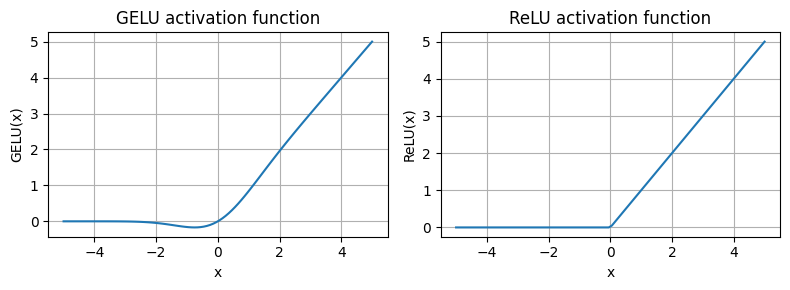

In [75]:
x = torch.linspace(-5, 5, 100)
y_gelu, y_relu = gelu(x), relu(x)
plt.figure(figsize=(8,3))
for i, (y, label) in enumerate(zip([y_gelu, y_relu], ["GELU", "ReLU"]), 1):
    plt.subplot(1, 2, i)
    plt.plot(x, y)
    plt.title(f"{label} activation function")
    plt.xlabel("x")
    plt.ylabel(f"{label}(x)")
    plt.grid(True)
plt.tight_layout()
plt.show()
    

In [79]:
class FFN(nn.Module):
    def __init__(self, cfg):
        super(FFN, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg['d_model'], 4 * cfg['d_model']),
            GELU(),
            nn.Linear(4 * cfg['d_model'], cfg['d_model']),
        )

    def forward(self, x):
        return self.layers(x)

X = torch.rand(2, 5, 768)
model = FFN(config)
out = model(X)
out.shape

torch.Size([2, 5, 768])

### Shortcut connections

Example: 2 linear layers each followed by GELU

X -> Linear -> GELU -> Out -> X = X + Out

X -> Linear -> GELU -> Out -> X = X + Out


In [89]:
class DeepNeuralNetwork(nn.Module):
    def __init__(self, layer_sizes, use_shortcut):
        super(DeepNeuralNetwork, self).__init__()
        self.use_shortcut = use_shortcut
        self.layers = nn.ModuleList([
            nn.Sequential(nn.Linear(layer_sizes[0], layer_sizes[1]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[1], layer_sizes[2]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[2], layer_sizes[3]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[3], layer_sizes[4]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[4], layer_sizes[5]), GELU()),
        ])

    def forward(self, x):
        # x: (B, T, d_model)
        for layer in self.layers:
            layer_output = layer(x)
            if self.use_shortcut and x.shape == layer_output.shape:
                x = x + layer_output
            else:
                x = layer_output
        return x

X = torch.rand(2, 4096, 4608)
num_layers = 6
layer_sizes = [4608] * num_layers
model = DeepNeuralNetwork(layer_sizes, use_shortcut=True)
out = model(X)
out.shape

torch.Size([2, 4096, 4608])

## Connecting all individual blocks to make a transformer decoder block

Requires - 
1. MultiHeadAttention (refer 03_multi_head_attention.ipynb)
2. FeedForward
3. LayerNorm
4. Dropout

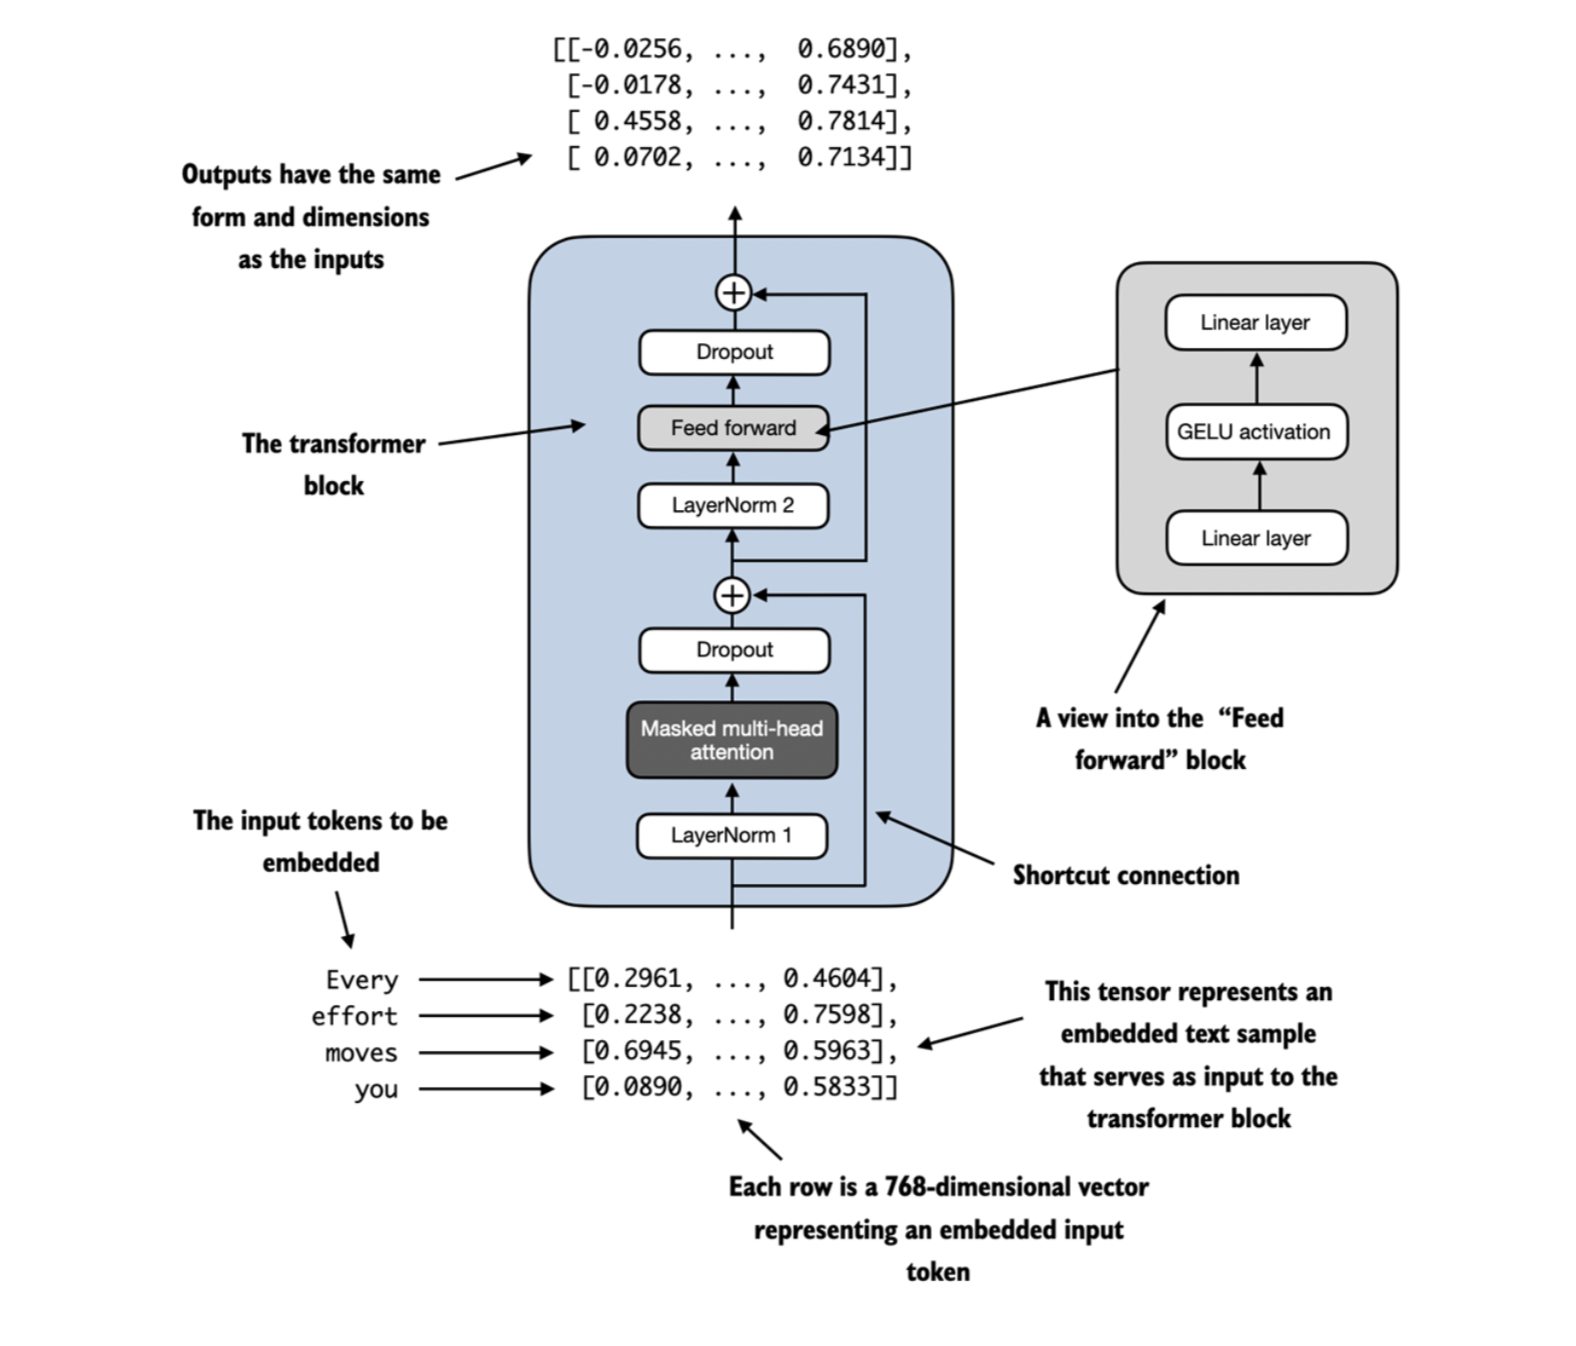

#### Revisiting multiheadattention again

In [113]:
class MultiHeadAttention(nn.Module):
    def __init__(self, T, d_model, num_heads, drop_rate, qkv_bias=False):
        super(MultiHeadAttention, self).__init__()
        assert d_model % num_heads == 0, "d_model should be divisible by num_heads"
        
        self.T = T
        self.d_model =  d_model
        self.num_heads = num_heads
        self.head_dim = d_model // num_heads
        self.Wq = nn.Linear(d_model, d_model, bias=qkv_bias)
        self.Wk = nn.Linear(d_model, d_model, bias=qkv_bias)
        self.Wv = nn.Linear(d_model, d_model, bias=qkv_bias)

        self.dropout = nn.Dropout(drop_rate)
        self.out_proj = nn.Linear(d_model, d_model)

    def forward(self, x):
        # x: (B, T, embed_size)   # embed_size == d_model
        B = x.shape[0]

        queries = self.Wq(x)   # (B, T, d_model)
        keys = self.Wk(x)   # (B, T, d_model)
        values = self.Wv(x)   # (B, T, d_model)

        # Divide d_model in num_heads
        queries = queries.view(B, self.T, self.num_heads, self.head_dim)   # (B, T, num_heads, head_dim)
        keys = keys.view(B, self.T, self.num_heads, self.head_dim)   # (B, T, num_heads, head_dim)
        values = values.view(B, self.T, self.num_heads, self.head_dim)   # (B, T, num_heads, head_dim)

        queries = queries.transpose(1, 2)   # (B, num_heads, T, head_dim)
        keys = keys.transpose(1, 2)   # (B, num_heads, T, head_dim)
        values = values.transpose(1, 2)   # (B, num_heads, T, head_dim)
        
        # Compute attention scores
        attention_scores = queries @ keys.transpose(2, 3)   # (B, num_heads, T, T)

        # Compute attention weights
        mask = torch.triu(torch.ones(self.T, self.T), diagonal=1)   # (T, T)
        masked_attention_scores = attention_scores.masked_fill(mask.bool(), -torch.inf)  # (B, num_heads, T, T)
        attention_weights = torch.softmax( masked_attention_scores / keys.shape[-1] ** 0.5 , dim=-1)  # (B, num_heads, T, T)

        # Compute context vector
        Z = attention_weights @ values   # (B, num_heads, T, head_dim)
        Z = Z.contiguous()
        Z = Z.view(B, self.T, self.d_model)
        Z = self.out_proj(Z)

        return Z

B = 2
T = 4096
d_model = 4608
num_heads = 48
drop_rate = 0.5
X = torch.rand(B, T, d_model)
multiheadattention = MultiHeadAttention(T, d_model, num_heads, drop_rate)
out = multiheadattention(X)
out.shape


torch.Size([2, 4096, 4608])

#### Revisiting layernorm again

In [114]:
class LayerNorm(nn.Module):
    def __init__(self):
        super(LayerNorm, self).__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(d_model))
        self.shift = nn.Parameter(torch.zeros(d_model))
        
    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift

#### Revisiting GELU

In [115]:
class GELU(nn.Module):
    def __init__(self):
        super(GELU, self).__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh( torch.sqrt(torch.tensor( 2.0 / torch.pi )) * (x + 0.044715 * torch.pow(x, 3)) ))

#### Revisiting feedforwardNN

In [116]:
class FeedForwardNetwork(nn.Module):
    def __init__(self, cfg):
        super(FeedForwardNetwork, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg['d_model'], 4 * cfg['d_model']),
            GELU(),
            nn.Linear(4 * cfg['d_model'], cfg['d_model']),
        )

    def forward(self, x):
        return self.layers(x)

In [117]:
#### Buliding transformer block

In [119]:
class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super(TransformerBlock, self).__init__()
        self.norm1 = LayerNorm()
        self.norm2 = LayerNorm()
        self.drop_resd = nn.Dropout(cfg['drop_rate'])
        self.ffn = FeedForwardNetwork(cfg)
        self.attn = MultiHeadAttention(T=cfg['context_length'],
                                      d_model=cfg['d_model'],
                                      num_heads=cfg['num_heads'],
                                      drop_rate=cfg['drop_rate'],
                                      qkv_bias=cfg['qkv_bias'])

    def forward(self, x):
        # x: (B, T, embed_size)  embed_size == d_model
        shortcut = x              # (B, T, d_model)
        x = self.norm1(x)         # (B, T, d_model)
        x = self.attn(x)           # (B, T, d_model)
        x = self.drop_resd(x)     # (B, T, d_model)
        x = x + shortcut          # (B, T, d_model)

        shortcut = x
        x = self.norm2(x)         # (B, T, d_model)
        x = self.ffn(x)           # (B, T, d_model)
        x = self.drop_resd(x)     # (B, T, d_model)
        x = x + shortcut          # (B, T, d_model)

        return x

B = 2
T = config['context_length']
d_model = config['d_model']
num_heads = config['num_heads']
X = torch.rand(B, T, d_model)
model = TransformerBlock(config)
out = model(X)

print('X: ', X.shape)
print('out: ', X.shape)

X:  torch.Size([2, 1024, 768])
out:  torch.Size([2, 1024, 768])


## Building GPT
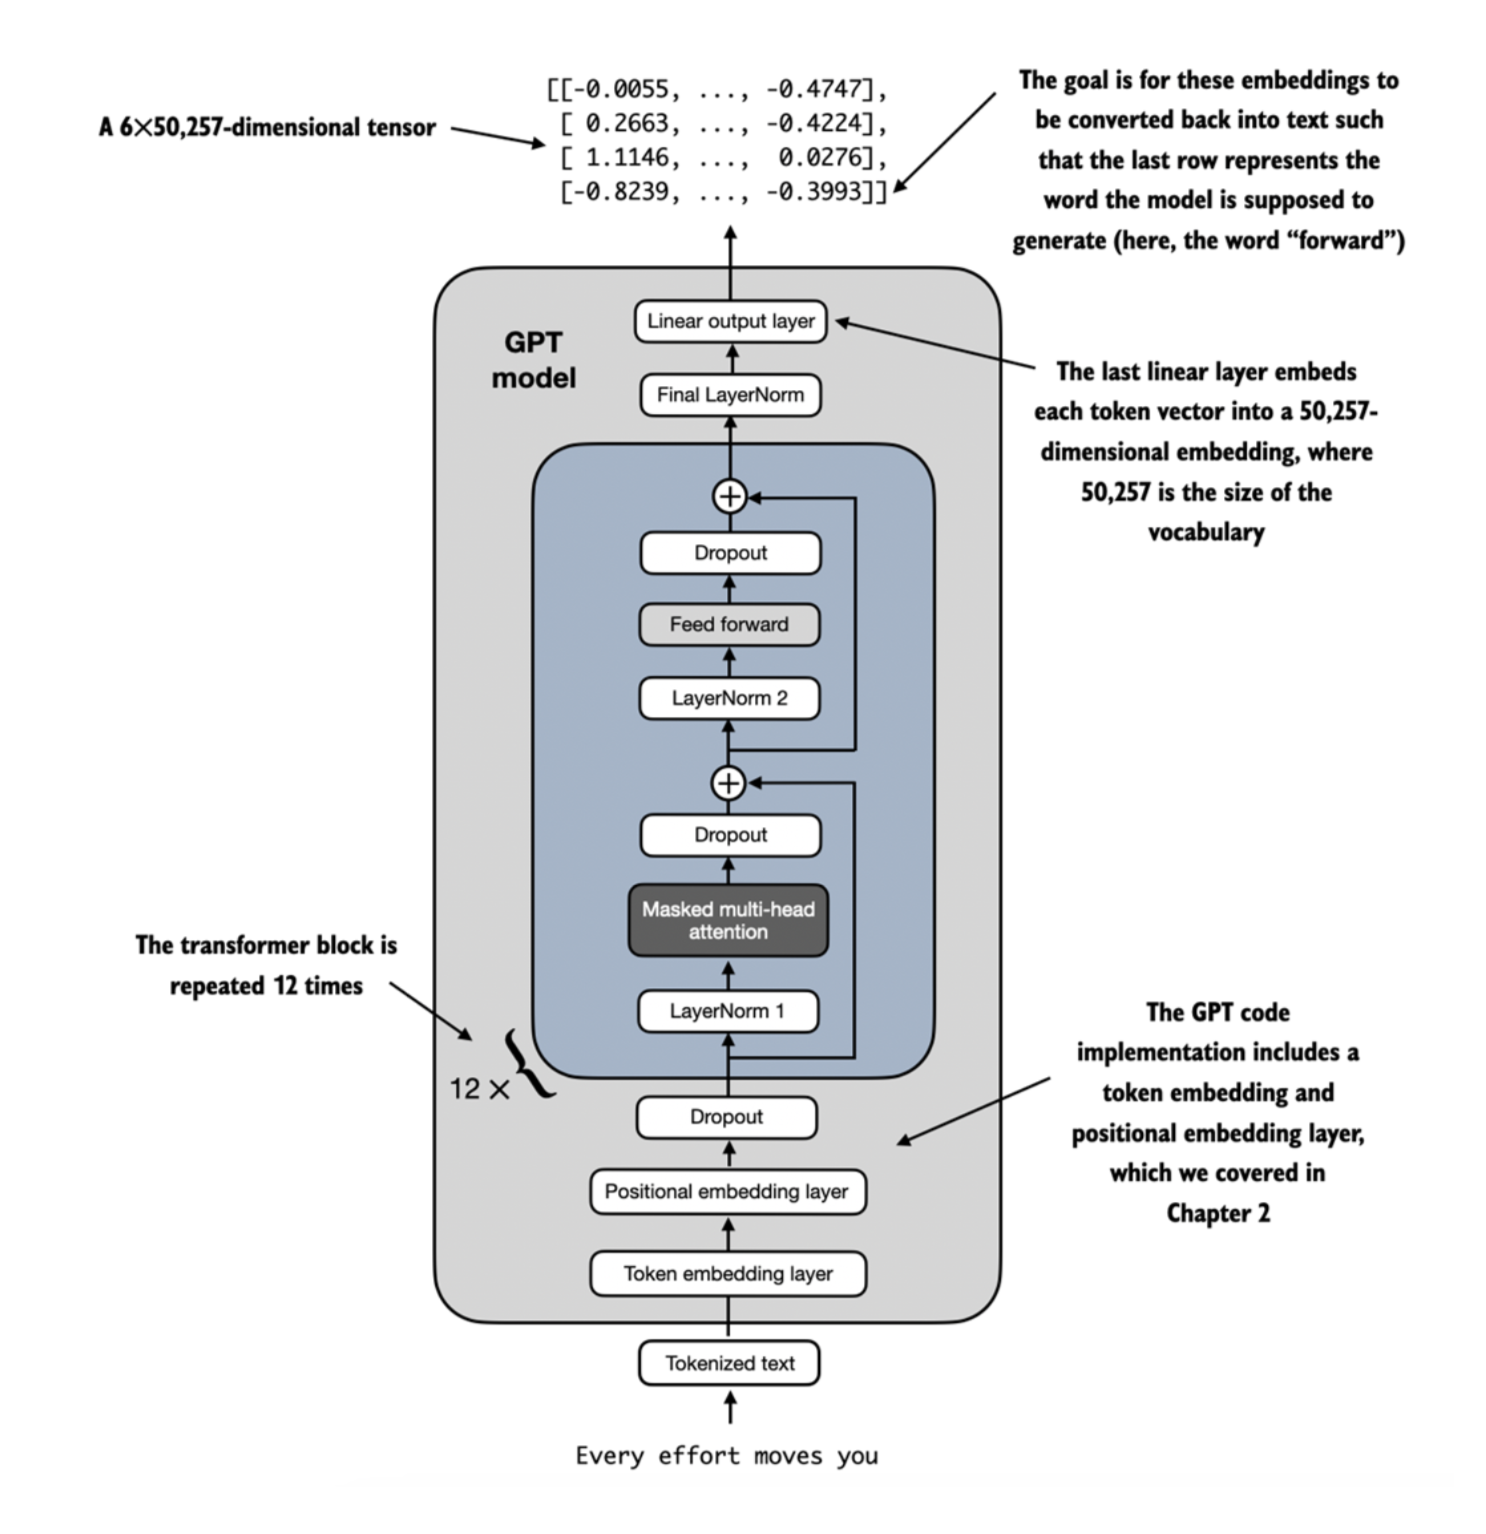

In [150]:
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super(GPTModel, self).__init__()
        self.tok_emb = nn.Embedding(cfg['vocab_size'], cfg['d_model'])
        self.pos_emb = nn.Embedding(cfg['context_length'], cfg['d_model'])
        self.dropout = nn.Dropout(cfg['drop_rate'])
        self.transformer_blocks = nn.Sequential(*[TransformerBlock(cfg) for _ in range(cfg['num_layers'])])
        self.final_norm = LayerNorm()
        self.out_head = nn.Linear(cfg['d_model'], cfg['vocab_size'], bias=False)

    def forward(self, inputs):
        # inputs: (B, T)
        B, T = inputs.shape
        tok_embeds = self.tok_emb(inputs)   # (B, d_model)
        pos_embeds = self.pos_emb(torch.arange(T, device=inputs.device))  # (B, d_model)
        x = tok_embeds + pos_embeds
        x = self.dropout(x)
        x = self.transformer_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

model = GPTModel(config)
model

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (dropout): Dropout(p=0.1, inplace=False)
  (transformer_blocks): Sequential(
    (0): TransformerBlock(
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_resd): Dropout(p=0.1, inplace=False)
      (ffn): FeedForwardNetwork(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (attn): MultiHeadAttention(
        (Wq): Linear(in_features=768, out_features=768, bias=False)
        (Wk): Linear(in_features=768, out_features=768, bias=False)
        (Wv): Linear(in_features=768, out_features=768, bias=False)
        (dropout): Dropout(p=0.1, inplace=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
      )
    )
    (1): TransformerBlock(
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_resd

In [151]:
B = 2
T = config['context_length']
X = torch.randint(0, config['vocab_size'], (B, T))
out = model(X)

print('X: ', X.shape)
print('out: ', out.shape)

X:  torch.Size([2, 1024])
out:  torch.Size([2, 1024, 50257])
